# RF Signal Integrity to Power Integrity:  Part 11 SEPIA on Time-Domain for ZOUT

## Copyright Notice

````
========  SEPIA on QSPICE V202  ========
This "SEPIA" compiled binary (.dll) is Copyright © 2014 Picotest.
All rights reserved.
Please contact info@picotest.com for more information.
========================================
````


This folder contains the 3rd simulation of the  
["part11"](https://www.microwavejournal.com/blogs/32-rf-signal-integrity-to-power-integrity) of a series blog/article  
[RF Signal Integrity to Power Integrity](https://www.microwavejournal.com/blogs/32-rf-signal-integrity-to-power-integrity) on  
[Microwave Journal](https://www.microwavejournal.com/).


# Install PyQSPICE First!

In your cmd.exe window.
```
> pip install PyQSPICE
```

## Before Python Script

This folder contains files before running the Python Script.
The [**"Sim3.afterScript"**](https://github.com/Qorvo/QSPICE_on_MWJ/tree/main/Article11/Sim3.afterScript) folder next to this-folder is "after running script".


## Overview Part 11, Sim #3

In Part-11, throughout [QSPICE](qspice.com) simulations, we review Time-Domain base ZOUT with SEPIA.

In this Sim-3, we apply the SEPIA C++ block to an ideal step-down (buck) regulator.  
By starting from this time-domain ".TRAN" simulation model, WITHOUT making any AC-models, we extract frequency-domain loop infomration.

We do following steps of simulations:

**Section-2:**  
Run a transient ".TRAN" simulation on the schematic below.  
The SEPIA block generates "transient" and "ac" simulation models based on extracted parameters.

**Section-3:**  
Run the transient ".TRAN" simulation based on the SEPIA result from the section-2.

**Section-4:**  
Run an AC ".AC" simulation on the starting schematic below.  
This AC simualtion is for a waveform of VRM=OFF.

**Section-5:**  
Run the AC ".AC" simulation based on the SEPIA result from the section-2:

**Section-6:**  
Compare 3 (three) Zout Curves from
 a. Section-4
 b. Section-5
 c. data-processed Section-2

 **Section-7:**  
 We reconstruct the loop transfer function from "a" and "c" in the section-6.



## 1. Schematic and Netlist

We use below schmatic.

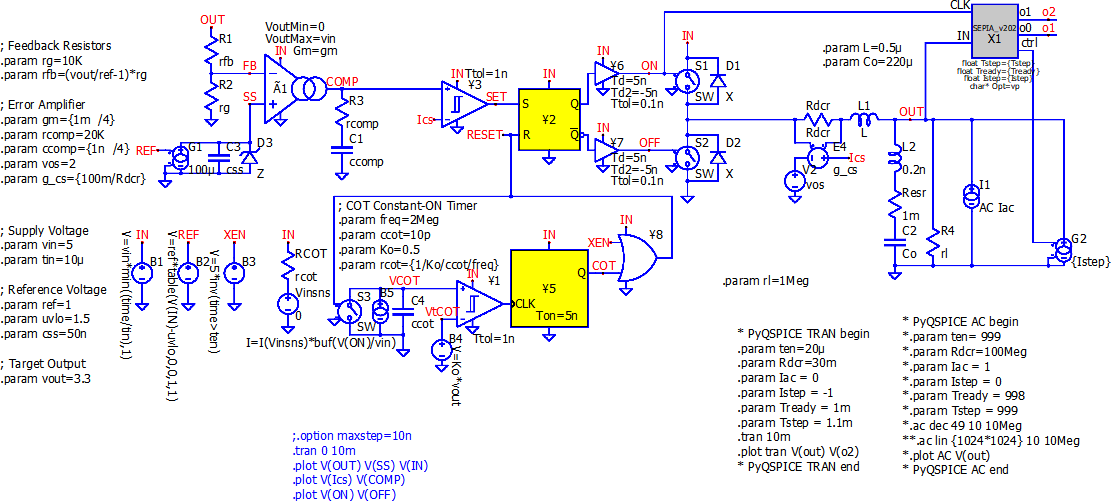

In [1]:
from PIL import Image
Image.open("Buck_SEPIA.sch.png")

In [2]:
from PyQSPICE import clsQSPICE as pqs

import datetime
import re
import subprocess
import math
import cmath

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as pat
from matplotlib.transforms import ScaledTranslation as stran

import numpy as np
from numpy import sin, cos, pi, linspace

fname = "Buck_SEPIA"
run = pqs(fname)
run.qsch2cir()
run.cir4label('ac')
run.cir4label('tran')

## 2. Transient Simulation: Execute SEPIA on the BUCK (Step-Down) VRM Model

### 2.1 Run a transient simulation

Now, we run a transient simulation with the step current load.

**NOTE:** This is a long simulation run, see the timestamps below observed at author's environment.

### 2.2 Q-Factor and phase-margin from SEPIA from "2.1"

(Continued from "2.1")
The beauty of SEPIA is that we know the key loop infomration from the simulation above "2.1".
We record the phase-maring here.

After running long operations after "2.3" in this notebook, we confirm that this SEPIA result is matching to the loop information.
In another word, SEPIA finishes its job by this point; all the rest of this notebook is to confirm this SEPIA result from the other method.


In [3]:
Ndata = 1024*1024
run.selectSimLabel('tran', Nline = Ndata, Nbit = 80)

sepiaTran = "_sepia_tran"
sepiaAC = "_sepia_ac"
sepiaLog = "_sepia_log"
run.opt4SEPIA(run.path['tran.cir'], prnPeak = True, Verbose = True,
              fnTran1 = sepiaTran, runTran1 = False, fnAC1 = sepiaAC, runAC1 = False, fnLog = sepiaLog)

print("Simulation started at " + str(datetime.datetime.now()))

run.cir2qraw()
#run.copy2qraw()  #use this line to re-use existing QRAW file

print("Simulation finished at " + str(datetime.datetime.now()))
print("Data Loading started at " + str(datetime.datetime.now()))

v = "V(OUT)"
i = "I(G2)"

dfTRAN = run.LoadQRAW([v,i])
#print(dfTRAN)

print("Data Loading finished at " + str(datetime.datetime.now()))

with open(sepiaLog + ".log") as f: textLog = f.read()
print(textLog)

sepiaPM = float((re.search(r"PM=([^,]+)\(deg\),", textLog)).group(1))
sepiafc = float((re.search(r"f=([^,]+)\(kHz\),", textLog)).group(1)) * 1e3

print("SEPIA: Phase-Margin = " + str(sepiaPM))
print("SEPIA: Unity-Gain Freq = " + str(sepiafc))

Simulation started at 2024-06-23 13:12:54.524354
Simulation finished at 2024-06-23 13:12:54.802833
Data Loading started at 2024-06-23 13:12:54.803827
Data Loading finished at 2024-06-23 13:13:41.310364

SEPIA: Tready=  0.001000, Tstep=  0.001100, Istep= -1.000000, Option:pvl_sepia_log:t1_sepia_tran:a1_sepia_ac:x
SEPIA: fTran1=_sepia_tran (Auto-Sim: OFF)
SEPIA: fAC1=_sepia_ac (Auto-Sim: OFF)
SEPIA: log=_sepia_log


========  SEPIA Result Begin  ========
SEPIA: Q= 1.54, Icoil/2=1.54e-03, f=17.75(kHz), T=56.34(us), PM=35.73(deg),
SEPIA: Z=4.26e-02, L=3.45e-07, C=1.91e-04, 
SEPIA: (sL+Rcoil) // ((1/sC)+Rcap) Modeling
  Rcoil+Rcap=2.76e-02,  Rcoil=1.43e-05,   Rcap=2.76e-02, 
SEPIA: (sL) // (1/sC) // Rdump Modeling
  Rdump=6.57e-02,  Rcoil=1.43e-05, 
SEPIA: preAve=3.30e+00, postAve=3.30e+00
========  SEPIA Result End    ========
SEPIA: n= 1.0, Vpk= -0.025592, Tpk= 11.205376(us), Tpp=  0.000000(us), dir=-1
SEPIA: n= 1.5, Vpk= +0.009780, Tpk= 39.443191(us), Tpp= 56.475630(us), dir=+1
SEPIA: n=

### 2.3 Filter-out switching ripple

For a better results of FFT, we take a moving-average of our FULL transient result.

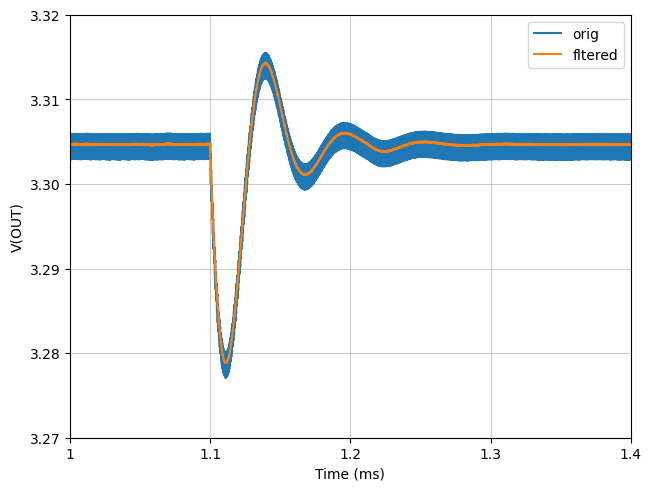

In [4]:
# We run the FuLL tran-sim for 10ms, and we have 1-meg (1024 x 1024) data lines, so the sampling period is ~10ns.
# Then, this sw-reg has 2MHz operation, which is ~500ns.
# In total, one (1) sw-reg switching-period is around 50 data points.
# This 50 data-point moving average eliminates switching ripple.
ra = np.ones(50) / 50

npTRANv = dfTRAN[v].to_numpy()
npTRANi = dfTRAN[i].to_numpy()
npTRANt = dfTRAN["Time"].to_numpy()

npTRANf = np.convolve(npTRANv, ra, mode="same")

plt.close('all')

fig, ax = plt.subplots(1, 1, sharex=True, constrained_layout=True)

ax.plot(npTRANt, npTRANv, label="orig")
ax.plot(npTRANt, npTRANf, label="fltered")

ax.legend()

run.PrepTimePlot(ax, "Time", r"V(OUT)", [1e-3, 1.4e-3], [3.27,3.32], "")
run.PrepTimePlot(ax, "Time", r"V(OUT)", "auto", "auto", "")

plt.savefig("Buck_SEPIA.tran.png", format='png', bbox_inches='tight')

plt.show()

## 3. Run SEPIA Extracted Transient Model

We run and compare the SEPIA result for transient response.

**NOTE:** We use the SHORT transient simulation result here.

* This file is generated by the SEPIA on QSPICE v202.
Vbias N03 0   3.30419480e+00
Rdcr N03 N02   1.43401578e-05
Lout N02 SEPIA_MODEL_FITTING   3.45485452e-07
Cout 0 SEPIA_MODEL_FITTING   1.90549433e-04

Rdump 0 SEPIA_MODEL_FITTING   6.56882907e-02
Istep 0 SEPIA_MODEL_FITTING pwl 0 0   1.10000000e-03 0   1.10000100e-03  -1.00000000e+00
.TRAN 0   1.00000000e-02 0 10n
.PLOT TRAN V(SEPIA_MODEL_FITTING)

############################################################################################
Simulation started at 2024-06-23 13:15:24.361630
Simulation finished at 2024-06-23 13:15:27.918565
Data Loading started at 2024-06-23 13:15:27.919525
Data Loading finished at 2024-06-23 13:15:29.610403


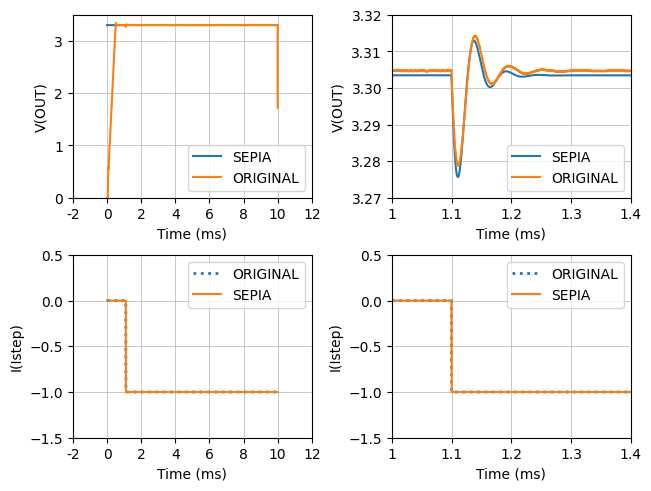

In [5]:
run2 = pqs(sepiaTran)

with open(run2.path['cir'], encoding='SJIS') as f: print(f.read())
#with open(sepiaLog + ".log") as f: print(f.read())

print("############################################################################################")

run2.setNline(1024 * 16)
run2.setNbit(80)
print("Simulation started at " + str(datetime.datetime.now()))
run2.cir2qraw()
#run2.copy2qraw()  #use this line to re-use existing QRAW file
print("Simulation finished at " + str(datetime.datetime.now()))
print("Data Loading started at " + str(datetime.datetime.now()))

v2 = "V(SEPIA_MODEL_FITTING)"
i2 = "I(Istep)"

dfTRAN2 = run2.LoadQRAW([v2,i2])
#print(dfTRAN2)
print("Data Loading finished at " + str(datetime.datetime.now()))

plt.close('all')

fig, ax = plt.subplots(2, 2, constrained_layout=True)

for n in [0, 1]:
    #dfTRAN.plot(ax=ax[0,n], x="Time", y=v, label="ORIGINAL", linestyle="dotted", linewidth=2)
    dfTRAN.plot(ax=ax[1,n], x="Time", y=i, label="ORIGINAL", linestyle="dotted", linewidth=2)
    dfTRAN2.plot(ax=ax[0,n], x="Time", y=v2, label="SEPIA")
    dfTRAN2.plot(ax=ax[1,n], x="Time", y=i2, label="SEPIA")
    ax[0,n].plot(npTRANt, npTRANf, label="ORIGINAL")
    ax[0,n].legend()

run2.PrepTimePlot(ax[0,0], "Time", r"V(OUT)", "auto", [0,3.5], "")
run2.PrepTimePlot(ax[1,0], "Time", r"I(Istep)", "auto", [-1.5,0.5], "")
run2.PrepTimePlot(ax[0,1], "Time", r"V(OUT)",   [1.05e-3,1.35e-3], [3.27,3.32], "")
run2.PrepTimePlot(ax[1,1], "Time", r"I(Istep)", [1.05e-3,1.35e-3], [-1.5,0.5], "")

plt.savefig("Buck_SEPIA.tran2.png", format='png', bbox_inches='tight')

plt.show()

## 4. AC Simulation: on the original model

We run an AC simulation by disabling the Buck VRM.


In [6]:
run.selectSimLabel('ac', Nline = 1024*4, Nbit = 80)

print("Simulation started at " + str(datetime.datetime.now()))
run.cir2qraw()
print("Simulation finished at " + str(datetime.datetime.now()))
print("Data Loading started at " + str(datetime.datetime.now()))

vac = "V(out)"
iac = "I(Iac)"

dfAC = run.LoadQRAW([vac])
print("Data Loading finished at " + str(datetime.datetime.now()))

#print(dfAC)
npACoffv = dfAC[vac].to_numpy()
npACofff = dfAC["Freq"].to_numpy()

Simulation started at 2024-06-23 13:15:56.152534
Simulation finished at 2024-06-23 13:15:56.540192
Data Loading started at 2024-06-23 13:15:56.540192
Data Loading finished at 2024-06-23 13:15:57.475817


## 5. Run SEPIA Extracted AC Model

We run the SEPIA result of AC model.

In [7]:
run3 = pqs(sepiaAC)

run3.setNline(1024*4)
run3.setNbit(80)
run3.cir2qraw()

v3 = "V(SEPIA_MODEL_FITTING)"
i3 = "I(Iac)"

print("Simulation started at " + str(datetime.datetime.now()))

dfAC2 = run3.LoadQRAW([v3,i3])

print("Simulation finished at " + str(datetime.datetime.now()))
print("Data Loading started at " + str(datetime.datetime.now()))

npAConv = dfAC2[v3].to_numpy()
npAConf = dfAC2["Freq"].to_numpy()

print("Data Loading finished at " + str(datetime.datetime.now()))

Simulation started at 2024-06-23 13:16:14.092699
Simulation finished at 2024-06-23 13:16:14.953774
Data Loading started at 2024-06-23 13:16:14.953774
Data Loading finished at 2024-06-23 13:16:14.954773


## 6. Compare Zout Curves

We compare below 3 output impedance curves.

1. VRM = OFF Zout curve from the original schematic
2. SEPIA extracted Zout curve
3. L( ddt( Vout_step_response )):  Laplace transforming derivative of Vout step response

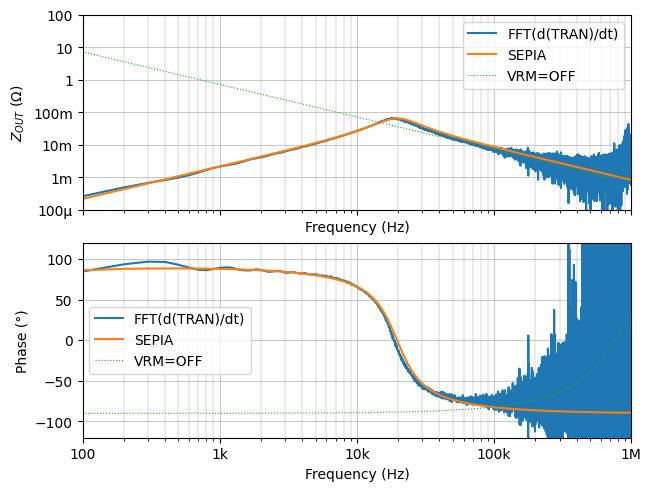

In [8]:
# Masking ramp-up waveform of VRM
# copy Vout @ 10%-point into all Vout data from 0 to 10%
npTRANf[0:int(Ndata/10)] = npTRANf[int(Ndata/10)]
npTRANf[int(Ndata*98/100):] = npTRANf[int(Ndata*98/100)]
#print(dfTRAN)

#print(npTRANf)
#print(npTRANi)

#dfVo = dfTRAN[v].diff().iloc[1:]
#dfIo = dfTRAN[i].diff().iloc[1:]
npVo = np.diff(npTRANf)
npIo = np.diff(npTRANi)
step = dfTRAN.iloc[1,0]

#print(npVo)
#print(npIo)

ftVo = (np.fft.fft(npVo))[0:int(Ndata/2)]
ftIo = (np.fft.fft(npIo))[0:int(Ndata/2)]
freq = (np.fft.fftfreq(Ndata,d=step))[0:int(Ndata/2)]

#print(ftVo)
#print(ftIo)

ZoFFT = (ftVo / ftIo)

absZfft = 20*np.log10(np.abs(ZoFFT))
angZfft = np.angle(ZoFFT) / np.pi * 180

##########################################

ZoSEPIA = np.interp(freq, npAConf, npAConv)

absZsepia = 20*np.log10(np.abs(ZoSEPIA))
angZsepia = np.angle(ZoSEPIA) / np.pi * 180

##########################################

absZoff = 20*np.log10(np.abs(npACoffv))
angZoff = np.angle(npACoffv) / np.pi * 180

##########################################

plt.close('all')

fig, (axT, axB) = plt.subplots(2, 1, sharex=True, constrained_layout=True)

axT.plot(freq, absZfft, label="FFT(d(TRAN)/dt)")
axB.plot(freq, angZfft, label="FFT(d(TRAN)/dt)")

axT.plot(freq, absZsepia, label="SEPIA")
axB.plot(freq, angZsepia, label="SEPIA")

axT.plot(npACofff, absZoff, label="VRM=OFF", linestyle="dotted", linewidth=0.8)
axB.plot(npACofff, angZoff, label="VRM=OFF", linestyle="dotted", linewidth=0.8)

axT.legend()
axB.legend()

run.PrepFreqImpePlot(axT, "Frequency (Hz)", r"$Z_{OUT}$ ($\Omega$)", "auto", [-80,40], "")
run.PrepFreqGainPlot(axB, "Frequency (Hz)", r"Phase (°)", [100,1e6], [-120,120], "")

plt.savefig("Buck_SEPIA.ac.png", format='png', bbox_inches='tight')

plt.show()

## 7. Reconstructing Loop Transfer Function

Based on the part-10, we have all the information to reconstruct the loop transfer function.

Now, we use the SEPIA results from "2.2".


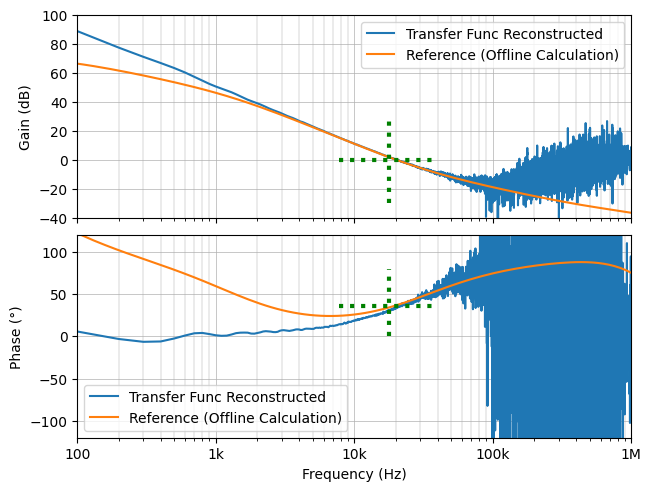

In [9]:
ZoOPN = np.interp(freq, npACofff, npACoffv)

TF = 1 - ZoOPN / ZoFFT

absT = 20*np.log10(np.abs(TF))
angT = np.angle(TF) / np.pi * 180

refAC = np.loadtxt("Buck_SEPIA_AC.csv", delimiter=',', skiprows=1)

plt.close('all')

fig, (axT, axB) = plt.subplots(2, 1, sharex=True, constrained_layout=True)

axT.plot(freq, absT, label="Transfer Func Reconstructed")
axB.plot(freq, angT, label="Transfer Func Reconstructed")
axT.plot(refAC[:,0], refAC[:,1], label="Reference (Offline Calculation)")
axB.plot(refAC[:,0], refAC[:,2], label="Reference (Offline Calculation)")

axT.legend()
axB.legend()

run.PrepFreqGainPlot(axT, "", "Gain (dB)", [], [-40,100], "")
run.PrepFreqGainPlot(axB, "Frequency (Hz)", r"Phase (°)", [100,1e6], [-120,120], "")

axT.plot([sepiafc, sepiafc], [-30,30], linewidth = 3, linestyle = "dotted", color="green")
axT.plot([(sepiafc-10e3), (sepiafc+20e3)], [0, 0], linewidth = 3, linestyle = "dotted",color="green")
axB.plot([sepiafc, sepiafc], [0,80], linewidth = 3, linestyle = "dotted",color="green")
axB.plot([(sepiafc-10e3), (sepiafc+20e3)], [sepiaPM, sepiaPM], linewidth = 3, linestyle = "dotted",color="green")

plt.savefig("Buck_SEPIA.loop.png", format='png', bbox_inches='tight')

plt.show()

## 8. Cleaning

Removing 1GB data file.

In [10]:
run.clean(['tran.qraw','ac.qraw'])
run2.clean(['qraw'])
run3.clean(['qraw'])